In [1]:
import io
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import re

# Import Dataset

The dataset 'divina_commedia.txt' is imported, containing the text of Dante's Divine Comedy. The file includes additional lines that are not part of the original text but provide information about the author.

In [2]:
print('Opening file...')
path = "divina_commedia.txt"
with io.open(path, encoding='utf-8') as file:
    text = file.read().lower()

print("text length", len(text))
print()
print('\n\n\n\n\n', '***** first 1000 characters *****', '\n\n\n\n\n')
text[0:1000]

Opening file...
text length 558240






 ***** first 1000 characters ***** 







"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

In [3]:
# Remove information about the author
text = re.sub(r"(e-text courtesy progetto manuzio)", "", text, flags=re.DOTALL)

print("text length", len(text))
print()
print('\n\n\n\n\n', '***** first 1000 characters *****', '\n\n\n\n\n')
text[0:1000]

text length 558176






 ***** first 1000 characters ***** 







"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

# Divide the sequences into training, validation and test sets

## Dividing the sequences into training, validation and test sets (**unbalanced approach**)

The dataset was divided into *canti*, with each canto randomly assigned to one of the sets: **training**, **validation** or **test**. Each canto belongs to only one set, and the final distribution of the dataset is: 70% for training, 20% for validation and 10% for testing.

Since the *canti* are assigned randomly, the results may vary, and the division might not be perfectly balanced.

For this initial model, the same architecture used during the lab was implemented.

### Preprocessing of unbalanced data

During the data preprocessing phase, the text is divided into individual *canti*, with unnecessary titles removed to retain only the 100 *canti* from the Divine Comedy

In [ ]:
canti = re.split(r'(?<=\n)(inferno|purgatorio|paradiso):\s*canto\s*[ivxlcdm]+\n*', text)

canti = [canto.strip() for canto in canti if canto.strip() and canto.lower() not in ['inferno', 'purgatorio', 'paradiso']]

# The first element of 'cantos', namely 'inferno', is removed from the list to obtain a list containing only the cantos.
if canti[0].lower() in ['inferno', 'purgatorio', 'paradiso']:
    canti = canti[1:]

print("Number of canti: ", len(canti))

# Print second canto
print(canti[1])

Number of canti:  100
lo giorno se n'andava, e l'aere bruno
  toglieva li animai che sono in terra
  da le fatiche loro; e io sol uno

m'apparecchiava a sostener la guerra
  si` del cammino e si` de la pietate,
  che ritrarra` la mente che non erra.

o muse, o alto ingegno, or m'aiutate;
  o mente che scrivesti cio` ch'io vidi,
  qui si parra` la tua nobilitate.

io cominciai: <<poeta che mi guidi,
  guarda la mia virtu` s'ell'e` possente,
  prima ch'a l'alto passo tu mi fidi.

tu dici che di silvio il parente,
  corruttibile ancora, ad immortale
  secolo ando`, e fu sensibilmente.

pero`, se l'avversario d'ogne male
  cortese i fu, pensando l'alto effetto
  ch'uscir dovea di lui e 'l chi e 'l quale,

non pare indegno ad omo d'intelletto;
  ch'e' fu de l'alma roma e di suo impero
  ne l'empireo ciel per padre eletto:

la quale e 'l quale, a voler dir lo vero,
  fu stabilita per lo loco santo
  u' siede il successor del maggior piero.

per quest'andata onde li dai tu vanto,
  intese cos

In [4]:
chars = sorted(list(set(text)))
print('total chars: ', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(char_indices)
print(indices_char)

total chars:  40
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z'}


### Definition of functions

In this section, the functions used for completing the assignment are defined

In [5]:
# This function divides the modified text into fixed-length sequences and associates the next character with each sequence

def generete_sequences(text, maxlen, step):
    sentences = []
    next_chars = []

    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])

    return sentences, next_chars

In [6]:
# The function converts the character sequences and target characters into one-hot representations

def encode_sequences(sentences, next_chars, maxlen, chars, char_indices):
    x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
    y = np.zeros((len(sentences), len(chars)), dtype=bool)

    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

    return x, y

In [7]:
# Print graphs of loss and accuracy

import matplotlib.pyplot as plt

def plot_performance(history):
    flg, ax = plt.subplots(1,2)
    flg.tight_layout()
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss')
    ax[0].plot(train_loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].legend()

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].plot(train_acc, label='Training Accuracy')
    ax[1].plot(val_acc, label='Validation Accuracy')
    ax[1].legend()

    plt.show()

In [8]:
import sys

def testAfterEpoch(epoch, _, maxlen, text, model):
    print()
    print()
    print('***** Epoch: %d *****' % (epoch+1))
    start_index = random.randint(0, len(text)- maxlen - 1)

    generated = ''
    sentence = text[start_index : start_index + maxlen]
    generated = generated + sentence

    print('***** starting sentence *****')
    print(sentence)
    print('*****************************')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [ ]:
# The code randomly splits the list "canti" into three subsets: training set, validation set, and test set, with proportions of 70%, 20% and 10% of total, resepctively

random.shuffle(canti)

train_size = int(0.7 * len(canti))
val_size = int(0.2 * len(canti))
test_size = len(canti) - train_size - val_size

train_canti = canti[:train_size]
val_canti = canti[train_size:train_size + val_size]
test_canti = canti[train_size + val_size:]

print(f"Training set: {len(train_canti)} canti")
print(f"Validation set: {len(val_canti)} canti")
print(f"Test set: {len(test_canti)} canti")

Training set: 70 canti
Validation set: 20 canti
Test set: 10 canti


## Model 1

In this model, the same architecture used during the lab has been applied. The main modification is that the model is trained on a text divided into *training*, *validation*, and *test* sets. Additionally, during training, *accuracy* is also monitored

In [ ]:
maxlen = 30 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  128555

  giu` nel secondo, che men l
o


In [ ]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (128555, 30, 40)
y_train shape: (128555, 40)
x_val shape: (37821, 30, 40)
y_val shape: (37821, 40)
x_test shape: (18765, 30, 40)
y_test shape: (18765, 40)


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
text_canti = ''.join(train_canti)

print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_canti,
        model
        )
    )

In [ ]:
history = model.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback],
        )

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.1708 - loss: 3.0630

***** Epoch: 1 *****
***** starting sentence *****
i si dice,
  di qua che dire e
*****************************
i si dice,
  di qua che dire e di si si se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se 
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 858ms/step - accuracy: 0.1715 - loss: 3.0585 - val_accuracy: 0.2936 - val_loss: 2.3692
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3088 - loss: 2.2679

***** Epoch: 2 *****
***** starting sentence *****
erso questa rivera,
  tanto ch
*****************************
erso questa rivera,
  tanto che l'alla che l'alla che

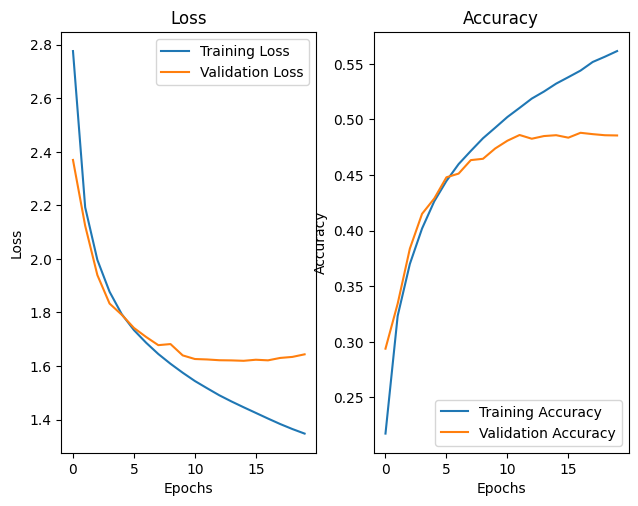

In [ ]:
plot_performance(history)

The **training loss** consistently decreases as the epochs progress, indicating that the model is learning from the training data. The **validation loss** initially decreases but stabilizes around 1.6, with a slight increase towards the end. This behavior could be a sign of overfitting, where the model is learning the training data too well and struggles to generalize to the validation data.

In the **accuracy** graph, the **training accuracy** curve steadily increases, surpassing 55%. On the other hand, the **validation accuracy** increases initially but stabilizes around 48% after a few epochs.

In both graphs, there is a growing gap between the training and validation curves after several epochs, suggesting that the model may be starting to overfit the training data

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6491461992263794
Test accuracy 0.4870237112045288


The results obtained are consistent with what is observed in the graphs, as the validation loss stabilizes around 1.6 and the test loss is very similar. Additionally, the validation accuracy stabilizes around 48%, which is perfectly aligned with the test accuracy.

From these results, it can be concluded that the model's performance is not optimal, as the accuracy is relatively low. Furthermore, the graphs clearly show signs of overfitting

## Dividing the sequence into training, validation and test sets (**balanced approach**)

In this second approach, the dataset is divided in two stages: first, it is separated by *cantiche*, and then each *cantica* is further split into individual *canti*. For each cantica, 70% of the canti are assigned to the training set, 20% to the validation set, and the remaining 10% to the test set. This method ensures a balanced representation of Dante's style across the three cantiche of the Divine Comedy

### Preprocessing of balanced data

In [9]:
# Split in the three cantiche
cantiche = re.split(r'\n(inferno|purgatorio|paradiso)\n', text)

cantiche = [canto.strip() for canto in cantiche if canto.strip() and canto.lower() not in ['inferno', 'purgatorio', 'paradiso']]

print(cantiche)
print("Total cantiche: ", len(cantiche))
print(cantiche[1])

['inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che\' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant\'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch\'i\' vi trovai,\n  diro` de l\'altre cose ch\'i\' v\'ho scorte.\n\nio non so ben ridir com\'i\' v\'intrai,\n  tant\'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch\'i\' fui al pie` d\'un colle giunto,\n  la` dove terminava quella valle\n  che m\'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de\' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m\'era durata\n  la notte ch\'i\' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l\'acqua perigliosa e guata,\

In [10]:
# Division of INFERNO
canti_inferno = re.split(r'(?<=\n)(inferno):\s*canto\s*[ivxlcdm]+\n*', cantiche[0])

canti_inferno = [canto.strip() for canto in canti_inferno if canto.strip() and canto.lower() not in ['inferno']]

# The first element of 'canti', namely 'Inferno', is removed from the list to obtain a list containing only the canti
if canti_inferno[0].lower() in ['inferno', 'purgatorio', 'paradiso']:
    canti_inferno = canti_inferno[1:]

print("Number of canti: ", len(canti_inferno))

train_size_inferno = int(0.7 * len(canti_inferno))
val_size_inferno = int(0.2 * len(canti_inferno))
test_size_inferno = len(canti_inferno) - train_size_inferno - val_size_inferno

train_inferno = canti_inferno[:train_size_inferno]
val_inferno = canti_inferno[train_size_inferno:train_size_inferno + val_size_inferno]
test_inferno = canti_inferno[train_size_inferno + val_size_inferno:]

print(f"Training set: {len(train_inferno)} canti")
print(f"Validation set: {len(val_inferno)} canti")
print(f"Test set: {len(test_inferno)} canti")

Number of canti:  34
Training set: 23 canti
Validation set: 6 canti
Test set: 5 canti


In [11]:
# Division of PURGATORIO
canti_purgatorio = re.split(r'(?<=\n)(purgatorio):\s*canto\s*[ivxlcdm]+\n*', cantiche[1])

canti_purgatorio = [canto.strip() for canto in canti_purgatorio if canto.strip() and canto.lower() not in ['purgatorio']]

# The first element of 'canti', namely 'Purgatorio', is removed from the list to obtain a list containing only the canti
if canti_purgatorio[0].lower() in ['purgatorio']:
    canti_purgatorio = canti_purgatorio[1:]

print("Number of canti: ", len(canti_purgatorio))

train_size_purgatorio = int(0.7 * len(canti_purgatorio))
val_size_purgatorio = int(0.2 * len(canti_purgatorio))
test_size_purgatorio = len(canti_purgatorio) - train_size_purgatorio - val_size_purgatorio

train_purgatorio = canti_purgatorio[:train_size_purgatorio]
val_purgatorio = canti_purgatorio[train_size_purgatorio:train_size_purgatorio + val_size_purgatorio]
test_purgatorio = canti_purgatorio[train_size_purgatorio + val_size_purgatorio:]

print(f"Training set: {len(train_purgatorio)} canti")
print(f"Validation set: {len(val_purgatorio)} canti")
print(f"Test set: {len(test_purgatorio)} canti")

Number of canti:  33
Training set: 23 canti
Validation set: 6 canti
Test set: 4 canti


In [12]:
# Division of PARADISO
canti_paradiso = re.split(r'(?<=\n)(paradiso):\s*canto\s*[ivxlcdm]+\n*', cantiche[2])

canti_paradiso = [canto.strip() for canto in canti_paradiso if canto.strip() and canto.lower() not in ['paradiso']]

# The first element of 'canti', namely 'Paradiso', is removed from the list to obtain a list containing only the canti
if canti_paradiso[0].lower() in ['paradiso']:
    canti_paradiso = canti_paradiso[1:]

print("Number of canti: ", len(canti_paradiso))

train_size_paradiso = int(0.7 * len(canti_paradiso))
val_size_paradiso = int(0.2 * len(canti_paradiso))
test_size_paradiso = len(canti_paradiso) - train_size_paradiso - val_size_paradiso

train_paradiso = canti_paradiso[:train_size_paradiso]
val_paradiso = canti_paradiso[train_size_paradiso:train_size_paradiso + val_size_paradiso]
test_paradiso = canti_paradiso[train_size_paradiso + val_size_paradiso:]

print(f"Training set: {len(train_paradiso)} canti")
print(f"Validation set: {len(val_paradiso)} canti")
print(f"Test set: {len(test_paradiso)} canti")

Number of canti:  33
Training set: 23 canti
Validation set: 6 canti
Test set: 4 canti


In [13]:
# Combines the subdivided canti for each cantica into their respective final sets
train_canti = train_inferno + train_purgatorio + train_paradiso
val_canti = val_inferno + val_purgatorio + val_paradiso
test_canti = test_inferno + test_purgatorio + test_paradiso

# Print the length of the sets
print(f"Training set: {len(train_canti)} canti")
print(f"Validation set: {len(val_canti)} canti")
print(f"Test set: {len(test_canti)} canti")

Training set: 69 canti
Validation set: 18 canti
Test set: 13 canti


In [14]:
text_for_training = ''.join(train_canti)

## Model 2

In this model, the network is trained using the text split obtained through the balanced approach. Using the same maxlen and step as in Model 1. Same network architecture used in the lab

In [ ]:
maxlen = 30 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126347
ta
  mi ritrovai per una selva
 


In [ ]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126347, 30, 40)
y_train shape: (126347, 40)
x_val shape: (33989, 30, 40)
y_val shape: (33989, 40)
x_test shape: (24811, 30, 40)
y_test shape: (24811, 40)


In [ ]:
model_b = Sequential()
model_b.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_b.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_b.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model_b.summary()

c:\Users\lperf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model_b
    )
)

In [ ]:
history_b = model_b.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback],
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.1699 - loss: 3.0686

***** Epoch: 1 *****
***** starting sentence *****
 pareva tardar troppo,
  grida
*****************************
 pareva tardar troppo,
  grida  e se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se 
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.1706 - loss: 3.0640 - val_accuracy: 0.2917 - val_loss: 2.3501
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.3136 - loss: 2.2459

***** Epoch: 2 *****
***** starting sentence *****
mi poli,

donne mi parver, non
*****************************
mi poli,

donne mi parver, non ch' l' l' mi li che l' l'

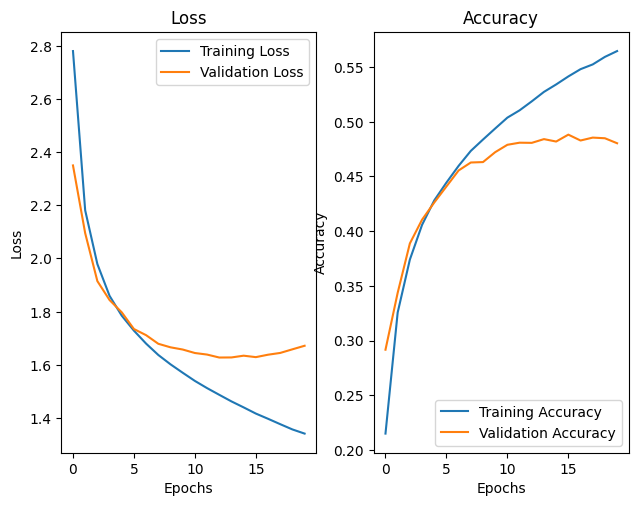

In [ ]:
plot_performance(history_b)

In the loss graph, the training curve continues to decrease steadily, indicating that the model is learning effectively from the training data. The validation curve, on the other hand, stabilizes around 1.6 but shows a slight increase in the final epochs, suggesting the presence of overfitting. In the accuracy graph, the training curve steadily increases, reaching about 55%, while the validation curve stabilizes around 48%

In [ ]:
score = model_b.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6599279642105103
Test accuracy 0.4838176667690277


The results obtained are consistent with what was observed in the graphs, as the validation loss stabilizes around 1.6, with the test loss being very similar. Additionally, the validation accuracy stabilizes around 48%, which aligns closely with the test accuracy. For this model as well, it can be concluded that the performance is not optimal, as the accuracy is relatively low, and overfitting has been observed in the graphs.

The results of the two approaches are very similar. The unbalanced approach shows slightly better values, but this may vary due to the random assignment of the canti. Since the results are essentially similar, it has been decided to use the second approach, the balanced one, for the subsequent models

# Tune the chunk length

After splitting the dataset into training, validation, and test sets, the length of each text sequence used to train the model, known as the **chunk length**, is adjusted to see if it leads to better performance. In all these cases, the network architecture is the same as that used in the lab.

## Model 3

For this model, the value of the **maxlen** variable, which represents the chunk length, was increased to 50, while the **step** variable remained unchanged

In [ ]:
maxlen = 50 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126341
ta
  mi ritrovai per una selva oscura
  che' la di
r


In [ ]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126341, 50, 40)
y_train shape: (126341, 40)
x_val shape: (33982, 50, 40)
y_val shape: (33982, 40)
x_test shape: (24804, 50, 40)
y_test shape: (24804, 40)


In [ ]:
model3 = Sequential()
model3.add(LSTM(128, input_shape=(maxlen, len(chars))))
model3.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model3.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model3
    )
)

In [ ]:
history3 = model3.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback],
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.1777 - loss: 3.0515

***** Epoch: 1 *****
***** starting sentence *****
lui; ma del salire
  non m'accors'io, se non com'u
*****************************
lui; ma del salire
  non m'accors'io, se non com'ua che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che ch
62/62 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1783 - loss: 3.0471 - val_accuracy: 0.2642 - val_loss: 2.4457
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.3104 - loss: 2.2729

***** Epoch: 2 *****
***** starting sentence *****
no verranno a li due cozzi:
  questi resurgeranno 
**************************

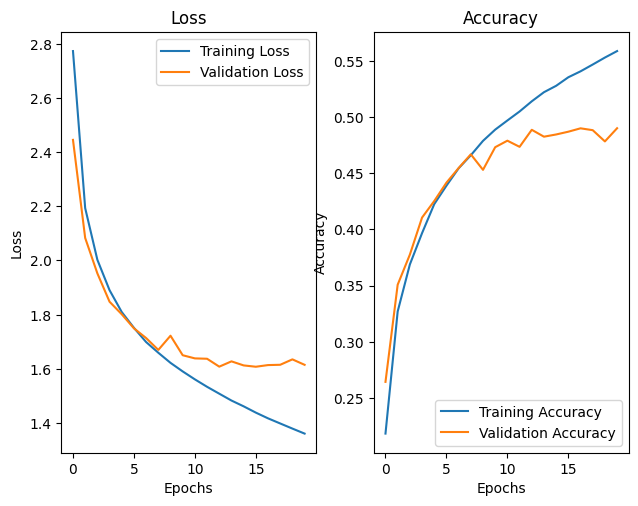

In [ ]:
plot_performance(history3)

In the loss graph, it can be observed that the training curve continues to decrease steadily, indicating that the model is learning effectively from the training data, while the validation curve stabilizes around 1.6. Compared to model 2, there is no increase towards the end in this case, but a clear gap between training and validation remains, indicating the presence of overfitting. In the accuracy graph, the training curve steadily increases, reaching about 55%, while the validation curve stabilizes around 48%.

In [ ]:
score = model3.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.624587059020996
Test accuracy 0.4911304712295532


The results obtained are consistent with what was observed in the graphs, as the validation loss stabilizes around 1.6, with the test loss being very similar. Additionally, the validation accuracy stabilizes around 48%, which is in perfect alignment with the test accuracy.

When comparing this model with Model 2, a slight improvement is observed, with a small decrease in loss and an increase of about one percentage point in accuracy. However, overfitting is still present.

## Model 4

In the previous model, the chunk length was increased. In this model, the goal is to analyze how the results change by reducing the *maxlen* value to 20 and also decreasing the *step* size, setting it from 3 to 2.

In [ ]:
maxlen = 20 # chunk length
step = 2

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  189526
i nostra vita
  mi r
i


In [ ]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (189526, 20, 40)
y_train shape: (189526, 40)
x_val shape: (50988, 20, 40)
y_val shape: (50988, 40)
x_test shape: (37221, 20, 40)
y_test shape: (37221, 40)


In [ ]:
model4 = Sequential()
model4.add(LSTM(128, input_shape=(maxlen, len(chars))))
model4.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model4.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model4
    )
)

In [ ]:
history4 = model4.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback],
        )

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.1975 - loss: 2.8995

***** Epoch: 1 *****
***** starting sentence *****
er 'tu m'appaghe',
 
*****************************
er 'tu m'appaghe',
  costo per a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por a por
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 477ms/step - accuracy: 0.1981 - loss: 2.8961 - val_accuracy: 0.3213 - val_loss: 2.1678
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3520 - loss: 2.0778

***** Epoch: 2 *****
***** starting sentence *****
e>>.

cosi` la circu
*****************************
e>>.

cosi` la circunto anter la perto manto si perto manto si perto manto si perto

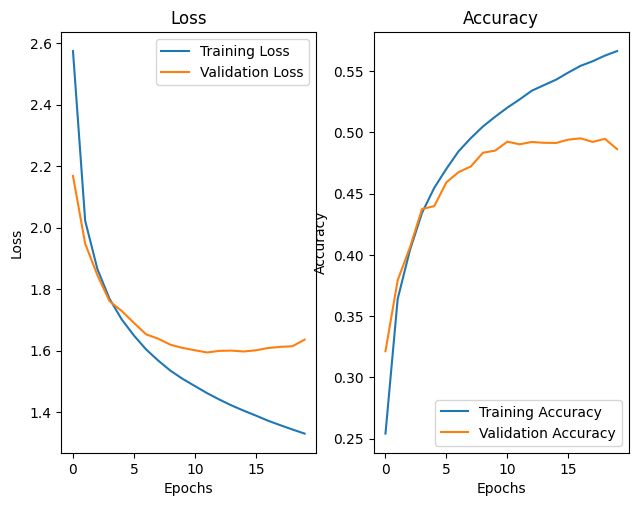

In [ ]:
plot_performance(history4)

From the loss graph, it can be observed that the training curve continues to decrease steadily, suggesting that the model is learning well from the training data. Meanwhile, the validation curve stabilizes around 1.6 but shows an increase in the final epochs, indicating the presence of overfitting. In the accuracy graph, the training accuracy steadily increases, reaching about 55%, while the validation accuracy stabilizes around 49%.

These graphs are very similar to those obtained from Model 2, as the gap between training and validation increases towards the last epochs. No significant improvement is observed.

In [ ]:
score = model4.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.6248489618301392
Test accuracy 0.49020713567733765


The results obtained are consistent with what is observed in the graphs, as the validation loss stabilizes around 1.6, with the Test Loss being very close. Similarly, the validation accuracy stabilizes around 0.49, which is perfectly in line with the Test accuracy.

The results obtained with a *maxlen* of 20 and a *step* of 2 are the best so far, showing a slight improvement compared to the previous models. The values, although similar to each other, have shown a general improvement.

## Model 5

In this model, it was decided to set the maxlen to a high value, while keeping the step at 3.

In [ ]:
maxlen = 80 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126331
ta
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi q
u


In [ ]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126331, 80, 40)
y_train shape: (126331, 40)
x_val shape: (33972, 80, 40)
y_val shape: (33972, 40)
x_test shape: (24794, 80, 40)
y_test shape: (24794, 40)


In [ ]:
model5 = Sequential()
model5.add(LSTM(128, input_shape=(maxlen, len(chars))))
model5.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model5.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model5.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model5
    )
)

In [ ]:
history5 = model5.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback],
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.1687 - loss: 3.0270

***** Epoch: 1 *****
***** starting sentence *****
 te, non mi domandi,
  che alcun altro in questa turba gaia.

tu credi 'l vero; 
*****************************
 te, non mi domandi,
  che alcun altro in questa turba gaia.

tu credi 'l vero;  che cora che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che che ch
62/62 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.1694 - loss: 3.0228 - val_accuracy: 0.2885 - val_loss: 2.3611
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.3170 - loss: 2.2439

***** Epoch: 2 *****
***** starting sentence *****
 torni a te da tu

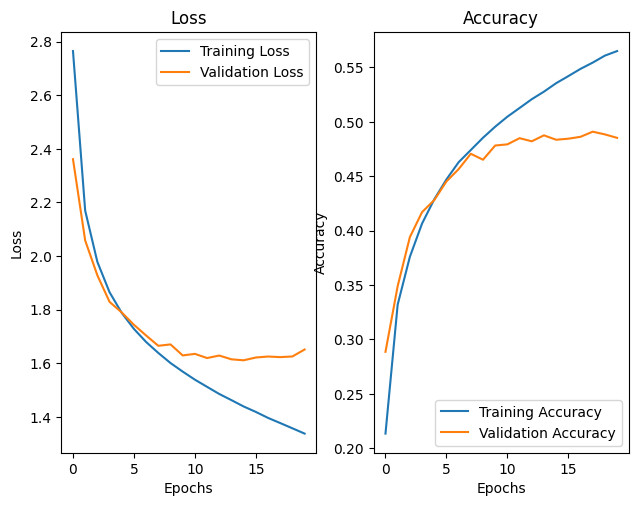

In [ ]:
plot_performance(history5)

From the Loss graph, it can be observed that the training curve continues to decrease steadily, indicating that the model is learning well from the training data. On the other hand, the validation curve stabilizes around 1.6 but shows a slight increase in the final epochs, indicating the presence of overfitting. In the accuracy graph, the training curve increases steadily, reaching about 55%, while the validation stabilizes around 48%.

In [ ]:
score = model5.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.657114028930664
Test accuracy 0.4858836829662323


The results obtained are consistent with what is observed in the graphs, as the validation loss stabilizes around 1.6, with the test loss being very similar. Similarly, the validation accuracy stabilizes around 0.48, perfectly aligning with the test accuracy.

Even for this model, the performance is not optimal, with relatively low accuracy and the presence of overfitting, as indicated by the graphs.

Compared to previous models, increasing the chunk length slightly worsened the performance, as overfitting was observed. Specifically, the test accuracy decreased, while the test loss increased.

## Model 6

In this model, it was decided to use a chunk length of 60, with the step set to 1.

In [16]:
maxlen = 60 # chunk length
step = 1

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  379011
el cammin di nostra vita
  mi ritrovai per una selva oscura

 


In [19]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (379011, 60, 40)
y_train shape: (379011, 40)
x_val shape: (101935, 60, 40)
y_val shape: (101935, 40)
x_test shape: (74402, 60, 40)
y_test shape: (74402, 40)


In [20]:
model_6 = Sequential()
model_6.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_6.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_6.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model_6.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model_6
    )
)

In [22]:
history_6 = model_6.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback],
        )

Epoch 1/20
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2289 - loss: 2.7152

***** Epoch: 1 *****
***** starting sentence *****
 guida,
  e fa cansar s'altra schiera v'intoppa>>.

or ci mo
*****************************
 guida,
  e fa cansar s'altra schiera v'intoppa>>.

or ci mossi a si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si s
186/186 ━━━━━━━━━━━━━━━━━━━━ 32s 164ms/step - accuracy: 0.2300 - loss: 2.7092 - val_accuracy: 0.3568 - val_loss: 2.0618
Epoch 2/20
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4036 - loss: 1.8738

***** Epoch: 2 *****
***** starting sentence *****
,
  trattando l'aere con l'etterne penne,
  che no

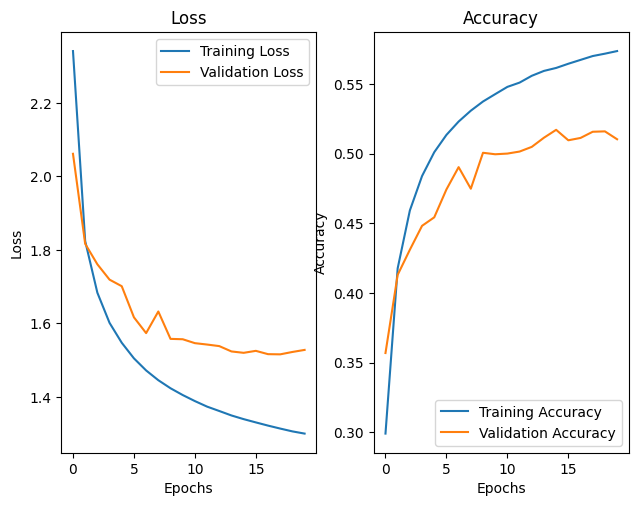

In [23]:
plot_performance(history_6)

From the loss graph, it can be observed that the training curve continues to decrease steadily, indicating that the model is learning effectively from the training data. On the other hand, the validation curve stabilizes around 1.5 but shows a slight increase in the later epochs, suggesting the presence of overfitting. In the accuracy graph, the training curve increases consistently, reaching about 55%, while the validation curve stabilizes around 50%.

In [24]:
score = model_6.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.5298869609832764
Test accuracy 0.5111287236213684


The results obtained are consistent with what is observed in the graphs, as the validation loss stabilizes around 1.5, and the test loss is very close. Additionally, the validation accuracy stabilizes around 50%, which aligns perfectly with the test accuracy.

This model shows good results compared to the previous ones, but it still suffers from overfitting. The performance is not optimal, as the accuracy remains relatively low.

For the four models just described, it can be concluded that by modifying the maxlen value, the results are very similar to each other, with slight improvements in test loss and test accuracy. In the graphs, there is a slight decrease in overfitting, although it remains present. The only model that showed better results, with a 3 percentage point increase in test accuracy, is the last model, but it also has overfitting. In conclusion, it can be said that the best model among those tested is model 6 (maxlen set to 60 and step 1), as it shows higher test loss and test accuracy values compared to the others.

# Modifications to the network architecture

In this final section, modifications to the network architecture are proposed with the aim of improving its performance.

## Model 7

From the models trained so far, it has been observed that all of them exhibit overfitting. As the first modification, the **Dropout** regularization technique is applied with a rate of 0.2 in an attempt to reduce overfitting. Additionally, a second LSTM layer with 128 neurons is added. For this new model, the maxlen is set to 50, and the step is set to 3, values taken from model 3, which provided average performance compared to the previously trained models. 

In [25]:
maxlen = 50 # chunk length
step = 3

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  126341
ta
  mi ritrovai per una selva oscura
  che' la di
r


In [26]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (126341, 50, 40)
y_train shape: (126341, 40)
x_val shape: (33982, 50, 40)
y_val shape: (33982, 40)
x_test shape: (24804, 50, 40)
y_test shape: (24804, 40)


In [27]:
from keras.layers import Dropout

model7 = Sequential()
model7.add(LSTM(128, input_shape=(maxlen, len(chars))))
model7.add(LSTM(128))
model7.add(Dropout(0.2))
model7.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model7.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model7.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model7
    )
)

In [29]:
history7 = model7.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback]
        )

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1702 - loss: 3.0495

***** Epoch: 1 *****
***** starting sentence *****
 al ciglio;
  e 'l gran centauro disse: <<e' son t
*****************************
 al ciglio;
  e 'l gran centauro disse: <<e' son te che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li che li
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 422ms/step - accuracy: 0.1710 - loss: 3.0451 - val_accuracy: 0.3065 - val_loss: 2.2975
Epoch 2/20
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3138 - loss: 2.2570

***** Epoch: 2 *****
***** starting sentence *****
nudo e dipelato vada,
  fu di grado maggior che tu
*************************

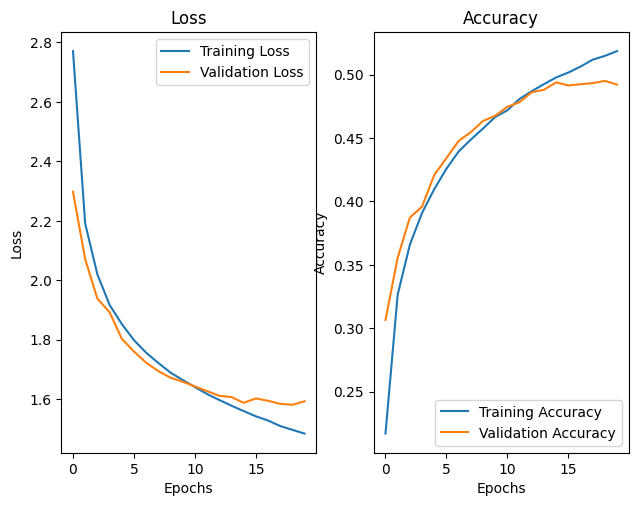

In [30]:
plot_performance(history7)

The loss graph shows that the training continues to decrease steadily, suggesting that the model is learning well from the training data, while the validation stabilizes around 1.6. In the accuracy graph, the training curve steadily increases, reaching about 48%, while the validation also stabilizes around 48%. The graphs reveal that overfitting is present, but not very evident; it has certainly decreased compared to previous models, as the training and validation curves for both loss and accuracy are closer to each other. Towards the end, a slight divergence begins to appear, indicating that overfitting is starting to emerge, but it is still reduced thanks to the use of Dropout.

In [31]:
score = model7.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.606020450592041
Test accuracy 0.4877842366695404


The results obtained are consistent with what is observed in the graphs, as the validation loss stabilizes around 1.6 and the test loss is very close. Similarly, the validation accuracy stabilizes around 0.48, which perfectly aligns with the test accuracy.

Although the graph does not show evident overfitting, the overall results are not optimal.

## Model 8

For this model, the same architecture as model 7 was chosen, as it provided good results while limiting overfitting. The only modification made was setting maxlen to 60 and step to 1, values that have yielded the best results so far in terms of test loss and test accuracy.

In [32]:
maxlen = 60 # chunk length
step = 1

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  379011
el cammin di nostra vita
  mi ritrovai per una selva oscura

 


In [33]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (379011, 60, 40)
y_train shape: (379011, 40)
x_val shape: (101935, 60, 40)
y_val shape: (101935, 40)
x_test shape: (74402, 60, 40)
y_test shape: (74402, 40)


In [35]:
model8 = Sequential()
model8.add(LSTM(128, input_shape=(maxlen, len(chars)), return_sequences=True))
model8.add(LSTM(128))
model8.add(Dropout(0.2))
model8.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model8.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model8.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 128)             │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,272 (872.16 KB)

 Trainable params: 223,272 (872.16 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model8
    )
)

In [37]:
history8 = model8.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback]
        )

Epoch 1/20
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1855 - loss: 3.0012

***** Epoch: 1 *****
***** starting sentence *****
enti

a chi avesse quei lumi divini
  veduti a noi venir, la
*****************************
enti

a chi avesse quei lumi divini
  veduti a noi venir, la sun conto sento sun conto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sconto sento sco
186/186 ━━━━━━━━━━━━━━━━━━━━ 43s 224ms/step - accuracy: 0.1861 - loss: 2.9969 - val_accuracy: 0.3248 - val_loss: 2.1509
Epoch 2/20
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3622 - loss: 2.0195

***** Epoch: 2 *****
***** starting sentence *****
o ad essi, fa che dopo il dosso
  ti stea un lume 

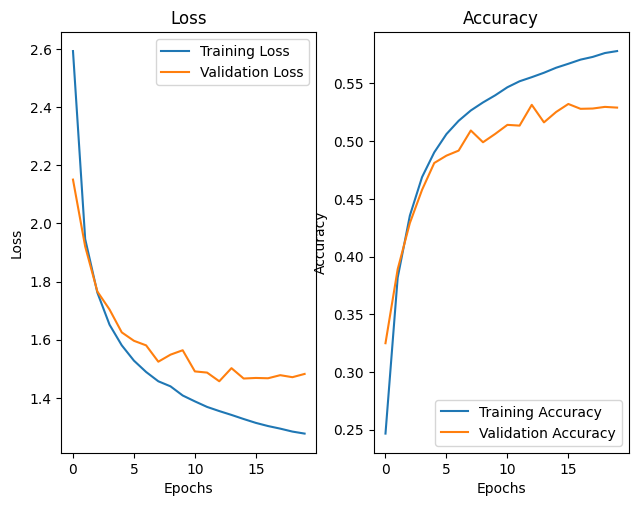

In [38]:
plot_performance(history8)

The loss graph shows that training continues to decrease steadily, indicating that the model is learning well from the training data. The validation, however, stabilizes around 1.5 but shows a slight increase in the last epochs, which suggests overfitting in the model. In the accuracy graph, the training curve increases steadily, reaching about 55%, while the validation stabilizes around 52%.

In [39]:
score = model8.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.4811185598373413
Test accuracy 0.5284401178359985


The results obtained are consistent with what is observed in the graphs, as the validation loss stabilizes around 1.5 and the test loss is very close (1.48). The validation accuracy stabilizes around 0.52, which perfectly aligns with the test accuracy.
This model shows good results compared to the previous ones, but it still exhibits overfitting, and the performance is not optimal, as the accuracy remains relatively low.

With maxlen set to 60 and step to 1, while using the same architecture as Model 7, we achieve better results in terms of test loss and test accuracy. However, what worsens is the graph, as Model 8 shows overfitting, a problem that was mitigated in Model 7.

## Model 9

For this model, it was decided to add a fully connected layer with 128 neurons and 'relu' as the activation function. A dropout rate of 0.2 was maintained to reduce overfitting. In this case, the chunk length is set to 60 and the step to 2.

In [25]:
maxlen = 60 # chunk length
step = 2

sentences_train, next_chars_train = generete_sequences(''.join(train_canti), maxlen, step)
sentences_val, next_chars_val = generete_sequences(''.join(val_canti), maxlen, step)
sentences_test, next_chars_test = generete_sequences(''.join(test_canti), maxlen, step)

print('number of sequences: ', len(sentences_train))
print(sentences_train[11])
print(next_chars_train[11])

number of sequences:  189506
i nostra vita
  mi ritrovai per una selva oscura
  che' la d
i


In [26]:
x_train, y_train = encode_sequences(sentences_train, next_chars_train, maxlen, chars, char_indices)
x_val, y_val = encode_sequences(sentences_val, next_chars_val, maxlen, chars, char_indices)
x_test, y_test = encode_sequences(sentences_test, next_chars_test, maxlen, chars, char_indices)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (189506, 60, 40)
y_train shape: (189506, 40)
x_val shape: (50968, 60, 40)
y_val shape: (50968, 40)
x_test shape: (37201, 60, 40)
y_test shape: (37201, 40)


In [27]:
from keras.layers import Dropout

model9 = Sequential()
model9.add(LSTM(256, input_shape=(maxlen, len(chars))))
model9.add(Dense(128, activation='relu'))
model9.add(Dropout(0.2))
model9.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model9.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
model9.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 256)            │       304,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,184 (1.31 MB)

 Trainable params: 342,184 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: testAfterEpoch(
        epoch,
        logs,
        maxlen,
        text_for_training,
        model9
    )
)

In [29]:
history9 = model9.fit(x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size = 2048,
        epochs = 20,
        callbacks = [print_callback]
        )

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.1381 - loss: 3.5694

***** Epoch: 1 *****
***** starting sentence *****
o
  fara` la prova; si` ch'a te fia bello
  averti fatta par
*****************************
o
  fara` la prova; si` ch'a te fia bello
  averti fatta par                                                                                                                                                                                                                                                                                                                                                                                                                
93/93 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.1384 - loss: 3.5653 - val_accuracy: 0.1805 - val_loss: 2.9729
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.1820 - loss: 2.9737

***** Epoch: 2 *****
***** starting sentence *****
se
  col punton de la spada, e <<fa che lavi,
  quando se

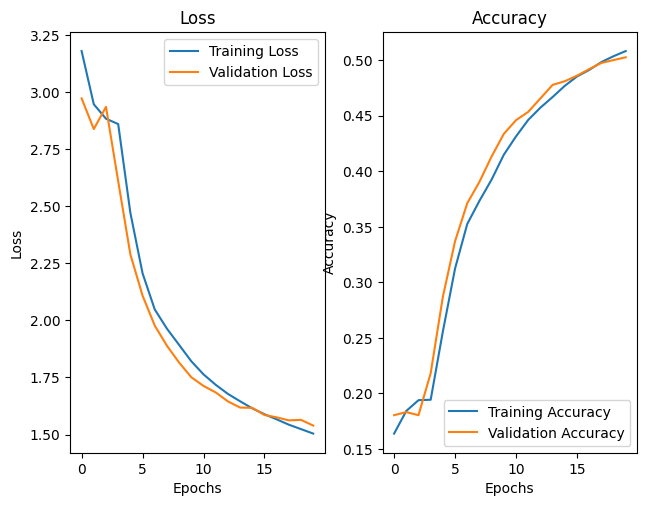

In [30]:
plot_performance(history9)

From the loss graph, it can be observed that the training loss decreases steadily and regularly, going from 3.2 to around 1.5. The validation loss closely follows the training loss, decreasing in a similar manner, with no signs of increasing towards the end of the epochs.
In the accuracy graph, the training accuracy curve increases steadily, starting at around 0.18 and reaching 0.51 by the end, while the validation accuracy follows the training curve almost perfectly, stabilizing around 51%.
Both the accuracy and loss curves are very close to each other and show no significant gap. This suggests that the model generalizes well on the validation data and learns consistently from both the training and validation data.

In [31]:
score = model9.evaluate(x_test, y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 1.5354753732681274
Test accuracy 0.5031585097312927


The results obtained are consistent with what is observed in the graphs, as the test loss is very close to the validation loss, indicating that the model generalizes well on the test data. The test accuracy is 0.50, a value very similar to the validation accuracy, confirming that the model behaves consistently and that the performance on the test data aligns with the validation performance.

With this latest model, we achieved good results in terms of validation, training, and test compared to the other models presented in this assignment. The graph shows no signs of overfitting; however, although the model's accuracy is among the highest, it remains relatively low. The same applies to the test loss, which, with a value of 1.53, is still too high.

# Conclusion

From the various models trained without regularization techniques, it was found that, despite modifying the maxlen value, the results were not satisfactory, and the graphs showed signs of overfitting.
To address this issue, Dropout was used as a regularization technique. Additionally, by adding an LSTM layer with 128 neurons, good results were achieved, using a maxlen of 50 and step 3. However, the best model was obtained by adding a fully connected layer and setting the maxlen to 60 with a step of 2. This eliminated overfitting from the graphs, and the test loss and test accuracy results were relatively good. Although the test accuracy is still low, compared to the other models in the assignment, it is one of the highest.